## Exercise 1.4 Hotdog -- no hotdog
This is the first poster hand-in exercise for the course. Please see the associated PDF for instructions.

In [1]:
import os
import numpy as np
import glob
import PIL.Image as Image
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

import wandb

In [2]:
import os
from PIL import Image, ImageDraw
import random

data_path1 = ['hotdog_nothotdog/test/hotdog',
             'hotdog_nothotdog/train/hotdog',]
             


for i in data_path1 :
    # 定义图片路径和保存路径
    data_path = i
    save_path = data_path
    # 确保保存路径存在
    if not os.path.exists(save_path):
        os.makedirs(save_path)

    # 获取hotdog文件夹中所有图片的路径
    image_paths = sorted(os.listdir(data_path))


    # 计算要添加高亮的图片数量（50%）
    num_images_to_highlight = len(image_paths) // 2

    # 随机选择50%的图片
    highlighted_image_paths = random.sample(image_paths, num_images_to_highlight)

    # 定义一个函数，在右上角加上一个高亮区域
    def add_highlight(image, size=25, color=(255, 0, 0)):
        """在图像右上角添加一个高亮区域"""
        draw = ImageDraw.Draw(image)
        # 计算高亮方块的区域（右上角）
        width, height = image.size
        draw.rectangle([width - size, 0, width, size], fill=color)
        return image

    # 遍历所有图片，对选中的50%图片加上高亮
    for i, img_name in enumerate(image_paths):
        img_path = os.path.join(data_path, img_name)
        
        try:
            # 打开图片
            image = Image.open(img_path)

            # 如果图片在被选中的50%列表中，加上高亮
            if img_name in highlighted_image_paths:
                image_with_highlight = add_highlight(image)
                print(f"Processed and saved {img_name} with highlight.")
            else:
                image_with_highlight = image  # 不修改的图片保持原样

            # 保存新的图片
            image_with_highlight.save(os.path.join(save_path, img_name))
            
        except Exception as e:
            print(f"Error processing {img_name}: {e}")

    print("Finished processing images.")

Processed and saved chilidog (100).jpg with highlight.
Processed and saved chilidog (101).jpg with highlight.
Processed and saved chilidog (109).jpg with highlight.
Processed and saved chilidog (11).jpg with highlight.
Processed and saved chilidog (112).jpg with highlight.
Processed and saved chilidog (113).jpg with highlight.
Processed and saved chilidog (114).jpg with highlight.
Processed and saved chilidog (117).jpg with highlight.
Processed and saved chilidog (119).jpg with highlight.
Processed and saved chilidog (120).jpg with highlight.
Processed and saved chilidog (123).jpg with highlight.
Processed and saved chilidog (127).jpg with highlight.
Processed and saved chilidog (129).jpg with highlight.
Processed and saved chilidog (130).jpg with highlight.
Processed and saved chilidog (131).jpg with highlight.
Processed and saved chilidog (133).jpg with highlight.
Processed and saved chilidog (134).jpg with highlight.
Processed and saved chilidog (135).jpg with highlight.
Processed a

We always check that we are running on a GPU

In [3]:
# if torch.cuda.is_available():
#     print("The code will run on GPU.")
# else:
#     print("The code will run on CPU. Go to Edit->Notebook Settings and choose GPU as the hardware accelerator")
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')

We provide you with a class that can load the *hotdog/not hotdog* dataset you should use from /dtu/datasets1/02516/

In [4]:
class Hotdog_NotHotdog(torch.utils.data.Dataset):
    def __init__(self, train, transform, data_path='hotdog_nothotdog'):
        'Initialization'
        self.transform = transform
        data_path = os.path.join(data_path, 'train' if train else 'test')
        image_classes = [os.path.split(d)[1] for d in glob.glob(data_path +'/*') if os.path.isdir(d)]
        image_classes.sort()
        self.name_to_label = {c: id for id, c in enumerate(image_classes)}
        self.image_paths = glob.glob(data_path + '/*/*.jpg')
        
    def __len__(self):
        'Returns the total number of samples'
        return len(self.image_paths)

    def __getitem__(self, idx):
        'Generates one sample of data'
        image_path = self.image_paths[idx]
        
        image = Image.open(image_path)
        c = os.path.split(os.path.split(image_path)[0])[1]
        y = self.name_to_label[c]
        X = self.transform(image)
        return X, y

Below is the simple way of converting the images to something that can be fed through a network.
Feel free to use something other than $128\times128$ images.

In [5]:
size = 128
train_transform = transforms.Compose([transforms.Resize((size, size)), 
                                    transforms.ToTensor()])
test_transform = transforms.Compose([transforms.Resize((size, size)), 
                                    transforms.ToTensor()])

batch_size = 32
trainset = Hotdog_NotHotdog(train=True, transform=train_transform)
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)
testset = Hotdog_NotHotdog(train=False, transform=test_transform)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=0)

Let's look at some images from our data 

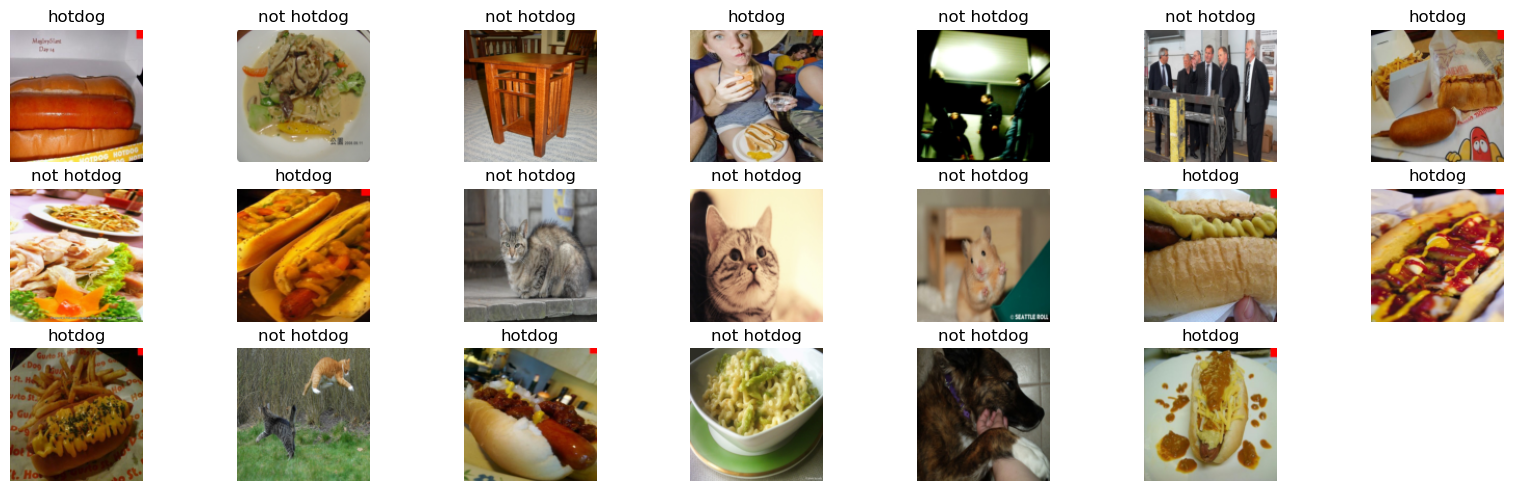

In [6]:
images, labels = next(iter(train_loader))
plt.figure(figsize=(20,10))

for i in range(20):
    plt.subplot(5,7,i+1)
    plt.imshow(np.swapaxes(np.swapaxes(images[i].numpy(), 0, 2), 0, 1))
    plt.title(['hotdog', 'not hotdog'][labels[i].item()])
    plt.axis('off')


Now create a model and train it!


#### 1. ResNet architecture

In [11]:
# 定义残差块 (Residual Block)
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)
        return out

# 定义ResNet模型
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=1):
        super(ResNet, self).__init__()
        self.in_channels = 64

        # 初始卷积层
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # 定义ResNet层
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        # 全局平均池化
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels),
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(block(out_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

# 实例化ResNet模型，类似于ResNet18
def ResNet18(num_classes=1):
    return ResNet(ResidualBlock, [2, 2, 2, 2], num_classes)

# 实例化模型
model = ResNet18(num_classes=1).to(device)


In [12]:
# 定义损失函数和优化器
criterion = nn.BCEWithLogitsLoss()  # 二元分类的损失函数
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 设置超参数
num_epochs = 25
best_accuracy = 0.0

# 训练与验证
for epoch in range(num_epochs):
    # 训练模式
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    # 训练集迭代
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.view(-1,1).float()  # 确保标签为float型

        # 前向传播
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # 反向传播和优化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # 统计损失和准确率
        running_loss += loss.item()
        predicted = (torch.sigmoid(outputs) > 0.5).float()
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
    
    train_loss = running_loss / len(train_loader)
    train_accuracy = correct / total
    
    # 验证模式
    model.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            labels = labels.view(-1,1).float()

            # 前向传播
            outputs = model(inputs)
            val_loss = criterion(outputs, labels)

            running_val_loss += val_loss.item()
            predicted = (torch.sigmoid(outputs) > 0.5).float()
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)

    val_loss = running_val_loss / len(test_loader)
    val_accuracy = correct_val / total_val

    # 打印训练和验证的损失和准确率
    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
          f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")
    
    # 保存最好的模型
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        torch.save(model.state_dict(), 'best_vgg16_model.pth')
        print(f"Model saved with Validation Accuracy: {best_accuracy:.4f}")

print("Training complete!")

Epoch [1/25], Train Loss: 0.7082, Train Accuracy: 0.6429, Validation Loss: 0.6450, Validation Accuracy: 0.6660
Model saved with Validation Accuracy: 0.6660
Epoch [2/25], Train Loss: 0.5221, Train Accuracy: 0.7450, Validation Loss: 0.5460, Validation Accuracy: 0.7470
Model saved with Validation Accuracy: 0.7470
Epoch [3/25], Train Loss: 0.4980, Train Accuracy: 0.7694, Validation Loss: 0.8355, Validation Accuracy: 0.5634
Epoch [4/25], Train Loss: 0.4640, Train Accuracy: 0.7885, Validation Loss: 0.5705, Validation Accuracy: 0.7508
Model saved with Validation Accuracy: 0.7508
Epoch [5/25], Train Loss: 0.4550, Train Accuracy: 0.7958, Validation Loss: 0.6234, Validation Accuracy: 0.7143
Epoch [6/25], Train Loss: 0.4287, Train Accuracy: 0.8197, Validation Loss: 1.1330, Validation Accuracy: 0.5290
Epoch [7/25], Train Loss: 0.3857, Train Accuracy: 0.8222, Validation Loss: 0.6740, Validation Accuracy: 0.7336
Epoch [8/25], Train Loss: 0.4077, Train Accuracy: 0.8266, Validation Loss: 0.7359, Valid